In [ ]:
import numpy as np
import inspect
from jax import grad
import jax.numpy as jnp

import time
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (11, 7)

$$ y = e^x \space sin \bigg( \frac{e^x + 2}{3} \bigg) $$

$$ \int y \space dx = -3 \space cos \bigg( \frac{e^x + 2}{3} \bigg) +C $$

In [ ]:
def func(x):
    y = np.exp(x) + 2
    y = y / 3
    y = np.sin(y) * np.exp(x)
    return y

def integral_func(x, C=0):
    y = np.exp(x) + 2
    y = y / 3
    y = np.cos(y) * (-3)
    return y + C

def integral_over_segment(seg=[-10, 10], C=0):
    x1 = seg[0]
    x2 = seg[1]
    Y1 = integral_func(x1)
    Y2 = integral_func(x2)
    return Y2 - Y1

In [ ]:
print(f'Analytical value of an integral of the function is {integral_over_segment():.4f}')

Analytical value of an integral of the function is 4.1753


**Trapezoidal rule**:

$$ \int^{b}_{a} f(x) dx \approx \sum^{N}_{k=1} \frac{f(x_{k-1}) + f(x_{k})}{2}\Delta x_{k}, $$

if $\Delta x_{k} = const$ :

$$ \int^{b}_{a} f(x) dx \approx \frac{\Delta x}{2} \big( f(x_0) + 2f(x_1) + 2f(x_2) + \dots + 2f(x_{N-1}) + f(x_N) \big) \approx \Delta x \bigg( \sum^{N-1}_{k=1} f(x_k) + \frac{f(x_N) + f(x_0)}{2} \bigg) $$

In [ ]:
def numpy_trapezoidal_integral(func, seg, N):
    assert inspect.isfunction(func)
    assert isinstance(seg, (list, tuple, set, np.ndarray))
    assert isinstance(N, int)
    
    a = seg[0]
    b = seg[1]
    delta_x = (b - a) / N
    
    # `x` space without bounds
    x_space = np.ones(N-1) * delta_x
    x_space[0] = a + delta_x
    x_space = np.cumsum(x_space)
    
    f_space = func(x_space)
    f_bounds = (func(a) + func(b)) / 2
    
    output = delta_x * (np.sum(f_space) + f_bounds)
    return output

def jfunc(x):
    y = jnp.exp(x) + 2
    y = y / 3
    y = jnp.sin(y) * jnp.exp(x)
    return y

func_deriv = grad(jfunc)

def integration_error(func_deriv, N, seg):
    a = seg[0]
    b = seg[1]

    error = (b - a) * (b - a)
    error = -error / (12 * N * N)
    error = error * (func_deriv(b) - func_deriv(a))
    return error

In [ ]:
numpy_trapezoidal_integral(func, seg=[-10, 10], N=100000000)

4.175341582581852

In [ ]:
%%timeit -r 1 -n 1
numpy_trapezoidal_integral(func, seg=[-10, 10], N=100000000)

12.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Parallel version


In [ ]:
!pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
def func(x):
    y = np.exp(x) + 2
    y = y / 3
    y = np.sin(y) * np.exp(x)
    return y


In [ ]:
%%timeit 

a = np.ones(int(1e8 / 8))
func(a)

702 ms ± 25.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit 

a = np.ones(int(1e8))
func(a)

5.79 s ± 279 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%writefile num_paral_integral.py
import numpy as np
import time
import inspect
from mpi4py import MPI

def func(x):
    y = np.exp(x) + 2
    y = y / 3
    y = np.sin(y) * np.exp(x)
    return y

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

calc_t = time.time()
mpi_wall_t = MPI.Wtime()

seg = [-10, 10]
N = 100000000

a = seg[0]
b = seg[1]
delta_x = (b - a) / N

# `x` space without bounds
x_space = np.ones(N-1) * delta_x
x_space[0] = a + delta_x
x_space = np.cumsum(x_space)

x_space_per_rank = np.array_split(x_space, size)
x_subspace = x_space_per_rank[rank]

f_subspace = np.sum(func(x_subspace))
f_space = comm.reduce(f_subspace, op=MPI.SUM, root=0)

if rank == 0:
    f_bounds = (func(a) + func(b)) / 2
    output = delta_x * (f_space + f_bounds)

    calc_t = time.time() - calc_t
    mpi_wall_t = MPI.Wtime() - mpi_wall_t

    np.savez('result_' + str(size) + '.npz', arr_0=output, calc_t=calc_t, mpi_wall_t=mpi_wall_t)

Overwriting num_paral_integral.py


In [ ]:
!mpirun --allow-run-as-root -n 1 python num_paral_integral.py

In [ ]:
!mpirun --allow-run-as-root -n 2 python num_paral_integral.py

In [ ]:
!mpirun --allow-run-as-root -n 3 python num_paral_integral.py

In [ ]:
!mpirun --allow-run-as-root -n 4 python num_paral_integral.py

In [ ]:
!mpirun --allow-run-as-root -n 5 python num_paral_integral.py

In [ ]:
!mpirun --allow-run-as-root -n 6 python num_paral_integral.py

In [ ]:
!mpirun --allow-run-as-root -n 7 python num_paral_integral.py

In [ ]:
!mpirun --allow-run-as-root -n 8 python num_paral_integral.py

--------------------------------------------------------------------------
mpirun noticed that process rank 0 with PID 0 on node 77e130b8ef70 exited on signal 9 (Killed).
--------------------------------------------------------------------------


In [ ]:
!mpirun --allow-run-as-root -n 9 python num_paral_integral.py

--------------------------------------------------------------------------
mpirun noticed that process rank 0 with PID 0 on node 77e130b8ef70 exited on signal 9 (Killed).
--------------------------------------------------------------------------


In [ ]:
source = np.load('result_5.npz')
value = source['arr_0']
value

array(4.17534158)

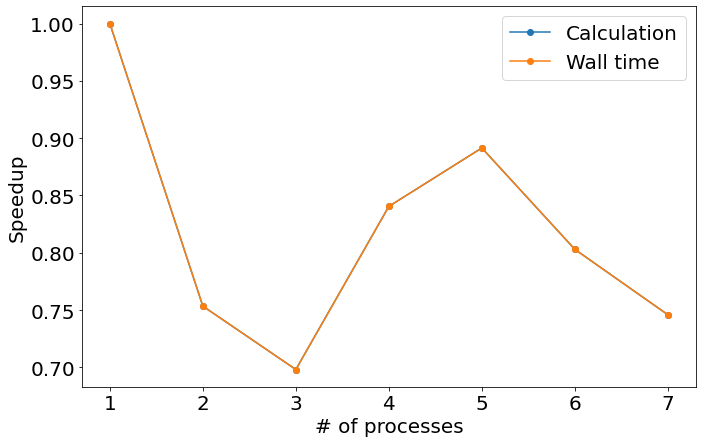

In [ ]:
calc_t = np.array([])
mpi_wall_t = np.array([])

for i in range(1, 8):
    source = np.load('result_' + str(i) + '.npz')
    calc_t = np.append(calc_t, source['calc_t'])
    mpi_wall_t = np.append(mpi_wall_t, source['mpi_wall_t'])

_, axes = plt.subplots(1, 1, figsize=(11, 7))

axes.plot(range(1, 8), calc_t[0] / calc_t, '-o', label='Calculation')
axes.plot(range(1, 8), mpi_wall_t[0] / mpi_wall_t, '-o', label='Wall time')

axes.set_xlabel('# of processes')
axes.set_ylabel('Speedup')
axes.legend();

In [ ]:
t_1 = time.time()
!mpirun --allow-run-as-root -n 1 python num_paral_integral.py
t_1 = time.time() - t_1

In [ ]:
t_2 = time.time()
!mpirun --allow-run-as-root -n 2 python num_paral_integral.py
t_2 = time.time() - t_2

In [ ]:
t_3 = time.time()
!mpirun --allow-run-as-root -n 3 python num_paral_integral.py
t_3 = time.time() - t_3

In [ ]:
t_4 = time.time()
!mpirun --allow-run-as-root -n 4 python num_paral_integral.py
t_4 = time.time() - t_4

In [ ]:
t_5 = time.time()
!mpirun --allow-run-as-root -n 5 python num_paral_integral.py
t_5 = time.time() - t_5

In [ ]:
t_6 = time.time()
!mpirun --allow-run-as-root -n 6 python num_paral_integral.py
t_6 = time.time() - t_6

In [ ]:
t_7 = time.time()
!mpirun --allow-run-as-root -n 7 python num_paral_integral.py
t_7 = time.time() - t_7

In [ ]:
t_8 = time.time()
!mpirun --allow-run-as-root -n 7 python num_paral_integral.py
t_8 = time.time() - t_8

In [ ]:
t_9 = time.time()
!mpirun --allow-run-as-root -n 7 python num_paral_integral.py
t_9 = time.time() - t_9

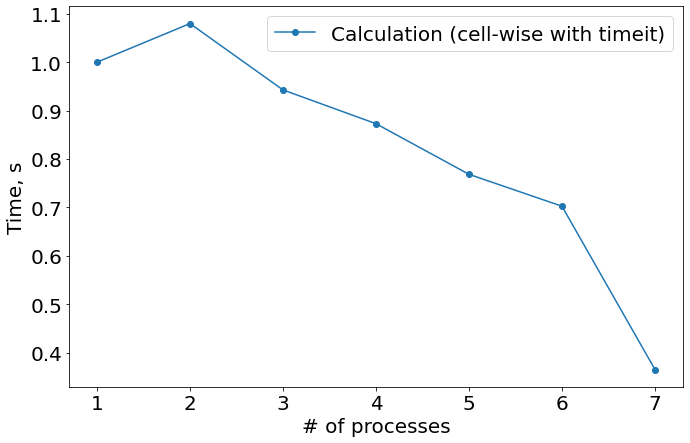

In [ ]:
plt.plot(range(1, 8), t_1 / np.array([t_1, t_2, t_3, t_4, t_5, t_6, t_7]), '-o', label='Calculation (cell-wise with timeit)')

plt.xlabel('# of processes')
plt.ylabel('Time, s')
plt.legend();

## Error vs discretization size

In [ ]:
err_ls = np.array([])
for n in 10 ** np.arange(8):
    err_ls = np.append(err_ls, integration_error(func_deriv, n, [-10., 10.]))

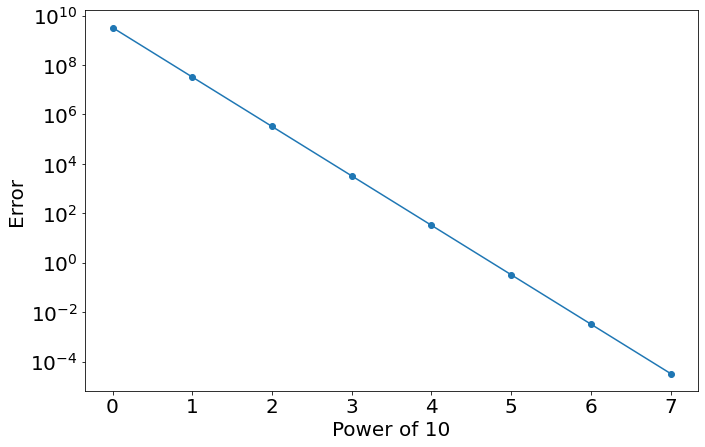

In [ ]:
plt.plot(np.arange(8), err_ls, '-o')
plt.xlabel('Power of 10')
plt.ylabel('Error')
plt.yscale('log');